In [4]:
import pickle
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

def load_cifar_batch(filename):
    """ 从单个 CIFAR 数据文件加载一个批次的数据 """
    with open(filename, 'rb') as f:
        data_dict = pickle.load(f, encoding='latin1')
        X = data_dict['data']
        Y = data_dict['labels']
        X = X.reshape(10000, 3, 32, 32).astype("float")
        Y = np.array(Y)
        return X, Y

def load_cifar10(data_dir):
    """ 从所有 CIFAR 文件加载整个数据集 """
    xs = []
    ys = []
    for batch in range(1, 6):
        f = os.path.join(data_dir, f'data_batch_{batch}')
        X, Y = load_cifar_batch(f)
        xs.append(X)
        ys.append(Y)
    X_train = np.concatenate(xs)
    Y_train = np.concatenate(ys)
    X_test, Y_test = load_cifar_batch(os.path.join(data_dir, 'test_batch'))
    return X_train, Y_train, X_test, Y_test

# 指定数据集路径
data_dir = "/Users/oliviagarbo/Documents/Deep learning/assignment 2/cifar-10-batches-py"

# 加载数据
X_train, Y_train, X_test, Y_test = load_cifar10(data_dir)

# 打印数据形状以验证加载成功
print("训练集图像数据形状:", X_train.shape)
print("训练集标签数据形状:", Y_train.shape)
print("测试集图像数据形状:", X_test.shape)
print("测试集标签数据形状:", Y_test.shape)

训练集图像数据形状: (50000, 3, 32, 32)
训练集标签数据形状: (50000,)
测试集图像数据形状: (10000, 3, 32, 32)
测试集标签数据形状: (10000,)


Epoch 1/50


/opt/anaconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


782/782 ━━━━━━━━━━━━━━━━━━━━ 193s 237ms/step - accuracy: 0.1399 - loss: 2.3815 - val_accuracy: 0.1632 - val_loss: 2.2772
Epoch 2/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 187s 239ms/step - accuracy: 0.2193 - loss: 2.1094 - val_accuracy: 0.2578 - val_loss: 2.0272
Epoch 3/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 186s 238ms/step - accuracy: 0.2661 - loss: 1.9553 - val_accuracy: 0.2879 - val_loss: 1.8841
Epoch 4/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 187s 239ms/step - accuracy: 0.3108 - loss: 1.8512 - val_accuracy: 0.3352 - val_loss: 1.7808
Epoch 5/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 189s 242ms/step - accuracy: 0.3435 - loss: 1.7735 - val_accuracy: 0.3595 - val_loss: 1.7394
Epoch 6/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 189s 241ms/step - accuracy: 0.3667 - loss: 1.7071 - val_accuracy: 0.3923 - val_loss: 1.6402
Epoch 7/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 189s 241ms/step - accuracy: 0.3936 - loss: 1.6469 - val_accuracy: 0.4195 - val_loss: 1.5678
Epoch 8/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 189s 242ms/step - accuracy: 0.4122 - loss: 1.58

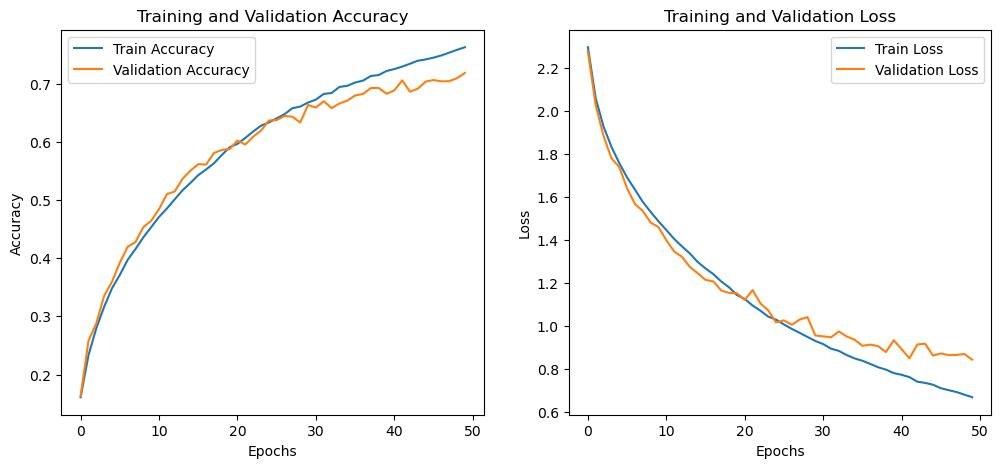

In [6]:
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

# 加载并预处理 CIFAR-10 数据集
(X_train, Y_train), (X_test, Y_test) = cifar10.load_data()
X_train = X_train.astype("float32") / 255.0
X_test = X_test.astype("float32") / 255.0
Y_train = tf.keras.utils.to_categorical(Y_train, 10)
Y_test = tf.keras.utils.to_categorical(Y_test, 10)

# 创建 MobileNet 模型
base_model = MobileNet(input_shape=(32, 32, 3), include_top=False, weights=None)
x = base_model.output
x = GlobalAveragePooling2D()(x)
outputs = Dense(10, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=outputs)

# 编译模型
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# 数据增强
datagen = ImageDataGenerator(
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)
datagen.fit(X_train)

# 设置 EarlyStopping 回调
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# 训练模型
history = model.fit(datagen.flow(X_train, Y_train, batch_size=64), 
                    epochs=50, 
                    validation_data=(X_test, Y_test), 
                    callbacks=[early_stop])

# 绘制准确率和损失曲线
plt.figure(figsize=(12, 5))

# 准确率曲线
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

# 损失曲线
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.show()

